In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

from textblob import TextBlob

%matplotlib inline

In [6]:
def loglikely(n1, t1, n2, t2):
    """Calculates Dunning log likelihood of an observation of 
    frequency n1 in a corpus of size t1, compared to a frequency n2 
    in a corpus of size t2. If result is positive, it is more 
    likely to occur in corpus 1, otherwise in corpus 2."""
    from numpy import log
    e1 = t1*1.0*(n1+n2)/(t1+t2) # expected values
    e2 = t2*1.0*(n1+n2)/(t1+t2)
    LL = 2 * ((n1 * log(n1/e1)) + n2 * (log(n2/e2)))
    if n2*1.0/t2 > n1*1.0/t1:
        LL = -LL
    return LL

Load curated dataset

In [84]:
df_curated = pd.read_csv('../twitfem/curated/davidt1.csv', encoding='latin-1')
df_curated = df_curated[['id', 'tweet', 'class']]
def assign_polarity(cell):
    return TextBlob(cell).polarity
df_curated['polarity'] = df_curated.tweet.apply(assign_polarity)
def assign_subjectivity(cell):
    return TextBlob(cell).subjectivity
df_curated['subjectivity'] = df_curated.tweet.apply(assign_subjectivity)

Automated sentiment analysis does not differentiate pro- and anti-feminist tweets

Here is the automated polarity and subjectivity of neutral tweets:

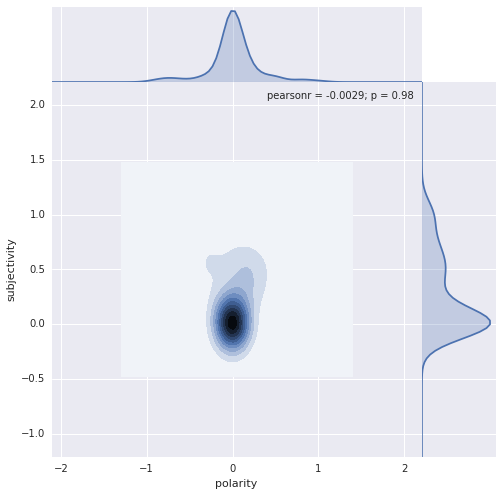

In [28]:
df_ = df[df['class'] == 0]
g = sns.jointplot(df_.polarity, df_.subjectivity, kind="kde", size=7, space=0)

Here is the automated polarity and subjectivity of pro-feminist tweets:

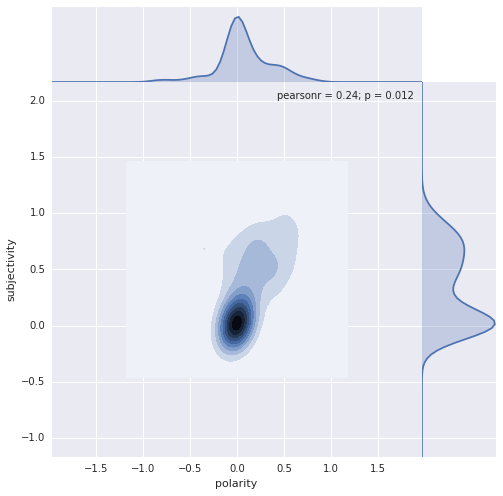

In [29]:
df_ = df[df['class'] == 1]
g = sns.jointplot(df_.polarity, df_.subjectivity, kind="kde", size=7, space=0)

Here is the automated polarity and subjectivity of anti-feminist tweets:

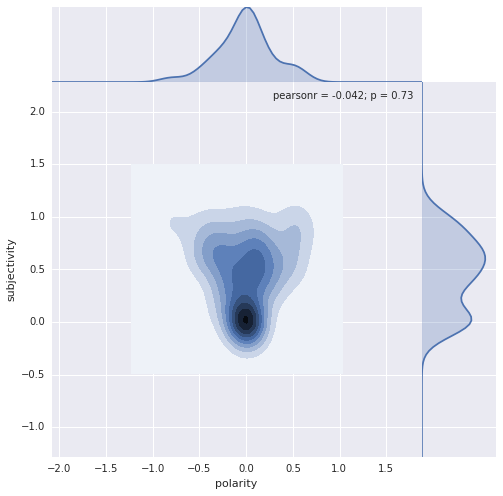

In [30]:
df_ = df[df['class'] == 2]
g = sns.jointplot(df_.polarity, df_.subjectivity, kind="kde", size=7, space=0)

A random forest classifier based on polarity and subjectivity achieves only 35.5% accuracy, compared to 33.3% for random choice.

In [39]:
from sklearn.ensemble import RandomForestClassifier
df['is_train'] = np.random.uniform(0, 1, len(df)) <= .75 # randomly assign training and testing set
train, test = df[df['is_train']==True], df[df['is_train']==False]
features = ['polarity', 'subjectivity']
y, _ = pd.factorize(train['class'])
clf = RandomForestClassifier(n_jobs=2)
clf = clf.fit(train[features], y)
preds = clf.predict(test[features])
test_result = pd.crosstab(test['class'], preds),
                      rownames=['actual'], colnames=['predicted'])
test_result

/software/CentOS-6/tools/python-3.3.2/lib/python3.3/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


predicted,0,1,2
actual,,,
0,4,19,2
1,2,17,11
2,5,13,6


In [77]:
df1M = pd.read_csv('../twitfem/twitfem.csv', encoding='latin-1')
print(len(df1M))
df_nort = df1M[~df1M.tweet.str.contains('RT')]
print(len(df_nort))

988202
CPU times: user 2min, sys: 274 ms, total: 2min
Wall time: 2min


Special tweet parser

In [7]:
## emoticons
emoticons_str = r"""
  (?:
    [:=;] # Eyes
    [oO\-]? # Nose (optional)
    [D\)\]\(\]/\\OpP] # Mouth
  )"""
 
## words
regex_str = [
  emoticons_str,
  r'<[^>]+>', # HTML tags
  r'(?:@[\w_]+)', # @-mentions
  r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
  r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs

  r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
  r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
  r'(?:[\w_]+)', # other words
  r'(?:\S)' # anything else
]

## compile regex
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)

def tokenize(string):
	return tokens_re.findall(string)

def removable(token):
	isEmoticon = True if emoticon_re.search(token) else False
	isRemovable = token in [',', '.', ':', ';']
	return (isEmoticon or isRemovable)

# pre_processor
def pre_process(string, lowercase=False):
	tokens = tokenize(string)
	tokens = [ token for token in tokens if not removable(token)]
	return tokens

Vectorize curated tweets and train a Naive Bayes classifier

In [141]:
df_curated.reindex(np.random.permutation(df_curated.index))
train_size = int(len(df_curated) * .75)
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer(tokenizer=pre_process)
bagofwords = vec.fit_transform(df_curated.tweet)
bagofwords = bagofwords.toarray()
train = bagofwords[:train_size,:]
test = bagofwords[train_size:,:]
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(train, df_curated[:train_size]['class'])
predicted = clf.predict(test)
pd.crosstab(df_curated[train_size:]['class'], predicted,
                      rownames=['actual'], colnames=['predicted'])

predicted,0,1,2
actual,,,
0,12,12,5
1,2,18,1
2,2,9,8


In [139]:
# another random set

predicted,0,1,2
actual,,,
0,12,14,5
1,2,21,1
2,2,11,8


Our classifier has 50-55% accuracy; better than 33.3%, to be sure

Predict the class of all 391,000 tweets

In [149]:
bagofwords = vec.fit(df_curated.tweet)
nort_vector = bagofwords.transform(df_nort.tweet)
predicted_nort = clf.predict(nort_vector)
df_nort['class'] = predicted_nort
df_nort.to_pickle('twitfem_391K_classified.pickle')

In [2]:
df_nort = pd.read_pickle('twitfem_391K_classified.pickle')

Function to count word frequencies

In [3]:
from collections import Counter
import pandas as pd

def countit(df, thisClass):
    df = df[df['class'] == thisClass]
    numItems = len(df)
    count = Counter()
    for key, row in df.iterrows():
        terms = [ term for term in pre_process( row['tweet'] ) ]
        count.update(terms)
        
    toBeReturned = pd.DataFrame(columns=['class', 'token', 'frequency'])
    tokenList = []
    frequencyList = []
    classList = []
    for token,frequency in count.items():
        tokenList.append(token)
        frequencyList.append(frequency)
        classList.append(thisClass)

    theDict = { 'token':tokenList, 'freq': frequencyList, 'class': classList } 
    return pd.DataFrame.from_dict(theDict)

In [ ]:
%%time
df_freqs = pd.concat([countit(df_nort, 1), countit(df_nort, 2)])

In [5]:
class ProgressBar: 
    """ Init with loop_length, i.e. number of events that add up to 100%, then use methods
    .increment() for each event, and .finish() when complete. """
    def __init__(self, loop_length):
        import time
        self.start = time.time()
        self.increment_size = 100.0/loop_length
        self.curr_count = 0
        self.curr_pct = 0
        self.overflow = False
        print('% complete:', end=' ')
    
    def increment(self):
        self.curr_count += self.increment_size
        if int(self.curr_count) > self.curr_pct:
            self.curr_pct = int(self.curr_count)
            if self.curr_pct <= 100:
                print (self.curr_pct, end=' ')
            elif self.overflow == False:
                print("\n*!* Count has gone over 100%; likely either due to:\n*!*   - an error in the loop_length specified when " + \
                      "progress_bar was instantiated\n*!*   - an error in the placement of the increment() function")
                print('*!* Elapsed time when progress bar full: %0.1f seconds.' % (time.time() - self.start))
                self.overflow = True

    def finish(self):
        if self.curr_pct == 99:
            print("100"), # this is a cheat, because rounding sometimes makes the maximum count 99. One day I'll fix this bug.
        if self.overflow == True:
            print('*!* Elapsed time after end of loop: %0.1f seconds.\n' % (time.time() - self.start))
        else:
            print('\nElapsed time: %0.1f seconds.\n' % (time.time() - self.start))

In [ ]:
df_freqs['loglikely'] = 0.0
t1 = df_freqs[df_freqs['class'] == 1].freq.sum()
t2 = df_freqs[df_freqs['class'] == 2].freq.sum()
tokens = []
loglikelies = []
for token in df_freqs.token.unique():
    try:
        n1 = df_freqs[(df_freqs['class'] == 1) & (df_freqs.token == token)].freq.iloc[0]
    except:
        n1 = 0
    try:
        n2 = df_freqs[(df_freqs['class'] == 2) & (df_freqs.token == token)].freq.iloc[0]
    except:
        n2 = 0
    if n1 > 1 and n2 > 1:
        tokens.append(token)
        loglikelies.append(loglikely(n1, t1, n2, t2))
df_result = pd.DataFrame({'token': tokens, 'loglikely': loglikelies})

In [ ]:
df_result.head(10)

In [ ]:
df_result.tail(10)